FIXME Rerun with more iterations and update based on output

# Determining Optimal Topic Count

## Table of Contents

1. [Introduction](#introduction)
2. [Analysis](#analysis)
    1. [Read Input Text for LDA](#read-input)
    2. [Compute Coherence Scores](#compute-coherence)
    3. [Plot Coherence (C) vs. Topic Count (k)](#plot-c-k)
    4. [Peek at Top 10 Coherence Scores](#peek-top-10)
    5. [Visualize Topics](#visualize-topics)
    6. [Display Topics in Interface](#display-topics)
3. [Conclusion](#conclusion)

## Introduction <a name='introduction'/>

> After scraping the text data and cleaning it up, we want to run LDA.
>
> The desired Topic Count (*k*) is currently unknown, but must be decided before running LDA.
>
> To determine *k*, we will use Coherence (*C*) as a quantitative measure of LDA.
>
> While this will provide evidence in choosing *k*, the determination of *k* still somewhat relies on intuition.
>
> The following will walk through the quantitative analysis.

## Analysis <a name='analysis'/>

### Read Input Text for LDA <a name='read-input'/>

In [6]:
from gensim.corpora.dictionary import Dictionary
from source_code.lda_helpers import read_lda_input  # Package with helpers

texts = read_lda_input('source_code/lda_input/lda_input.jl')
id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

### Compute Coherence Scores <a name='compute-coherence'/>

> Compute *C* for a range of values of *k*.
>
> Initial testing of LDA shows that the *k* will be low (< 10).
>
> This is mainly due to having sparse text data (small description text).
>
> Try with $k \in [2, 8]$.
>
> Attempt different RandomStates for each *k*, to get a better overall picture:
> * Average C per k
> * Max C per k

In [7]:
from collections import defaultdict
from numpy import mean
from source_code.lda_helpers import get_lda_model, compute_coherence  # Package with helpers
from tqdm.notebook import tqdm

k_range = range(2, 9)
attempts = 1

x_scatter = []
y_scatter = []
avgs = []
maxs = []
results = defaultdict(list)  # To display DataFrame later

# Run iterations
k_bar = tqdm(k_range, desc='Topic Counts', bar_format='{l_bar}{bar}{n_fmt}/{total_fmt}{postfix}')
i_bar = tqdm(total=len(k_range)*attempts, desc='Iterations', bar_format='{l_bar}{bar}{n_fmt}/{total_fmt} [Elapsed: {elapsed}, Remaining: {remaining}]')
for k in k_bar:
    k_bar.set_postfix_str(f'(Working on k={k})')
    cs = []  # C values for this k
    for i in range(attempts):
        r = i+1
        x_scatter.append(k)
        lda_model = get_lda_model(corpus, id2word, k, r)
        c = compute_coherence(lda_model, texts, corpus, id2word)
        cs.append(c)
        y_scatter.append(c)
        results['k'].append(k)
        results['r'].append(r)
        results['C'].append(c)
        i_bar.update()
    i_bar.refresh()
    avgs.append(mean(cs))
    maxs.append(max(cs))
    k_bar.set_postfix_str('')
i_bar.close()

### Plot Coherence (C) vs. Topic Count (k) <a name='plot-c-k'/>

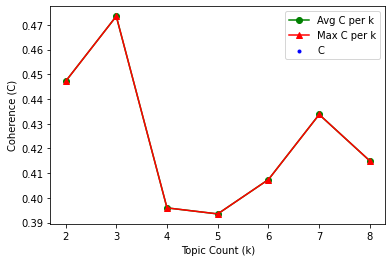

In [8]:
import matplotlib.pyplot as plt

plt.ylabel('Coherence (C)')
plt.xlabel('Topic Count (k)')

plt.scatter(results['k'], results['C'], c='b', marker=".", label='C')
plt.plot(k_range, avgs, 'go-', label='Avg C per k')
plt.plot(k_range, maxs, 'r^-', label='Max C per k')

plt.legend(bbox_to_anchor=(1,1))
plt.xticks(k_range)
plt.show()

### Peek at Top 10 Coherence Scores <a name='peek-top-10'/>

In [9]:
import pandas as pd

df = pd.DataFrame.from_dict(results)
df.sort_values(by='C', ascending=False, inplace=True, ignore_index=True)
df.head(10)

,k,r,C
0,3,1,0.473530
1,2,1,0.447129
2,7,1,0.433742
3,8,1,0.414935
4,6,1,0.407402
5,4,1,0.395923
6,5,1,0.393480


### Visualize Topics <a name='visualize-topics'/>

##### Run the best LDA <a name='run-best-lda'/>

In [10]:
k_best = df['k'].iloc[0]
r_best = df['r'].iloc[0]
lda_best = get_lda_model(corpus, id2word, k_best, r_best)

#### Display Topics in Interface <a name='display-topics'/>

In [11]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
LDAvis_display = pyLDAvis.gensim.prepare(lda_best, corpus, id2word)
LDAvis_display
pyLDAvis.save_html(LDAvis_display, 'lda.html')

## Conclusion <a name='conclusion'/>

> The quantitative output provides some assistance, and shows that *k* should be kept around 3 - 5.
>
> However, we also consider which topic count produces the best genres based on eyeballing the results.
>
> With these considerations in mind, we conclude that $k = 4$.